In [1]:
import torch
import mmcv
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot
import os
import numpy as np

/home/zhangzr/anaconda3/envs/Fault_Recong/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_file = '../../output/swin-base-patch4-window7_upernet_8xb2-160k_fault_public-128x128/swin-base-patch4-window7_upernet_8xb2-160k_fault_public-128x128.py'
checkpoint_file = '../../output/swin-base-patch4-window7_upernet_8xb2-160k_fault_public-128x128/iter_48000.pth'

In [3]:
# build the model from a config file and a checkpoint file
# model = init_model(config_file, checkpoint_file, device='cuda:0')
model = init_model(config_file, checkpoint_file, device='cpu')

/home/zhangzr/FaultRecongnition/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/zhangzr/FaultRecongnition/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ../../output/swin-base-patch4-window7_upernet_8xb2-160k_fault_public-128x128/iter_48000.pth


In [4]:
# test a single image
root_dir = '/home/zhangzr/FaultRecongnition/Fault_data/public_data/crop_2d_slices/train/image/'
idx = 0
img_lst = os.listdir(root_dir)
img = mmcv.imread(os.path.join(root_dir, img_lst[idx]), flag='unchanged')
# if not torch.cuda.is_available():
model = revert_sync_batchnorm(model)
result = inference_model(model, img)
pred = result.pred_sem_seg.data.detach().cpu().squeeze(0).numpy()
print(pred)
ann = mmcv.imread(os.path.join(root_dir.replace('image', 'ann'),img_lst[idx]), flag='unchanged')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


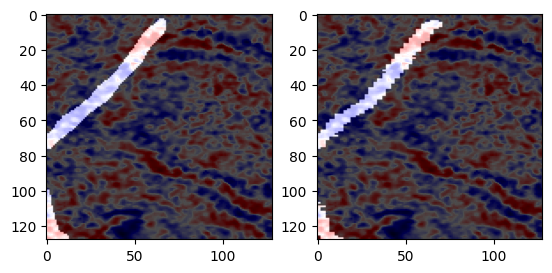

In [5]:
# show the results
# vis_result = show_result_pyplot(model, img, result)
# plt.imshow(mmcv.bgr2rgb(vis_result))
plt.subplot(1,2,1)
plt.imshow(img, cmap='seismic')
plt.imshow(pred, cmap='gray', alpha=0.7)
plt.subplot(1,2,2)
plt.imshow(mmcv.imread(img, flag='unchanged'), cmap='seismic')
plt.imshow(ann, cmap='gray', alpha=0.7)